In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score

In [62]:
df = pd.read_csv('/Users/mr.tian/Desktop/house_prices.csv')

In [93]:
df.head()

,Amount(in rupees),Price (in rupees),location,Floor,Transaction,Furnishing,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Carpet_Area_sqft,Status_Ready to Move
0,4200000.0,6000.0,thane,10 out of 11,Resale,Unfurnished,NaN,Main Road,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,500.0,1
1,9800000.0,13799.0,thane,3 out of 22,Resale,Semi-Furnished,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,473.0,1
2,14000000.0,17500.0,thane,10 out of 29,Resale,Unfurnished,East,Garden/Park,Sunrise by Kalpataru,2,NaN,1 Covered,Freehold,779.0,1
3,2500000.0,6034.0,thane,1 out of 3,Resale,Unfurnished,NaN,Main Road,NaN,1,1,NaN,NaN,530.0,1
4,16000000.0,18824.0,thane,20 out of 42,Resale,Unfurnished,West,"Garden/Park, Main Road",TenX Habitat Raymond Realty,2,NaN,1 Covered,Co-operative Society,635.0,1


In [99]:
df['Car Parking'] = df['Car Parking'].str.replace(',', '', regex=False).astype(str)

In [92]:
df.drop(columns=['Super Area', 'Dimensions', 'Plot Area'], axis=1, inplace=True)

In [87]:
df['overlooking'] = df['overlooking'].fillna(df['overlooking'].mode()[0])

In [73]:
df['Amount(in rupees)'] = df['Amount(in rupees)'].str.replace('Call for Price', 'None').astype(str)

In [74]:
df['Price (in rupees)'] = df['Price (in rupees)'].fillna(df['Price (in rupees)'].median())

In [75]:
df['Amount(in rupees)'] = (
    df['Amount(in rupees)']
    .str.replace('Lac', '* 100000', regex=False)
    .str.replace('Cr', '* 10000000', regex=False)
    .astype(str)
    .map(lambda x: eval(x) if x is not None else None)
)

In [77]:
df['Amount(in rupees)'] = df['Amount(in rupees)'].fillna(df['Amount(in rupees)'].median())

In [63]:
df.drop(columns='Index', axis=1, inplace=True)

In [64]:
df.drop(columns=['Title', 'Description'], axis=1, inplace=True)

In [65]:
s = df['Carpet Area'].astype(str)

def convert_area(x):
    if x is None or x == 'nan':
        return np.nan

    x = x.lower().strip()

    if 'sqm' in x:
        value = float(x.replace('sqm', '').strip())
        return value * 10.7639
    elif 'sqft' in x:
        return float(x.replace('sqft', '').strip())
    else:
        return np.nan

In [66]:
df['Carpet_Area_sqft'] = s.apply(convert_area)

In [68]:
df.drop(columns='Carpet Area', axis=1, inplace=True)

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187531 entries, 0 to 187530
Data columns (total 41 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Amount(in rupees)                         187531 non-null  float64
 1   Price (in rupees)                         187531 non-null  float64
 2   Bathroom                                  187531 non-null  int64  
 3   Balcony                                   187531 non-null  int64  
 4   Carpet_Area_sqft                          101322 non-null  float64
 5   Status_Ready to Move                      187531 non-null  int64  
 6   parking_count                             187531 non-null  Int64  
 7   has_parking                               187531 non-null  int64  
 8   floor_current                             187531 non-null  Int64  
 9   floor_total                               187531 non-null  Int64  
 10  floor_ratio         

In [178]:
df = pd.get_dummies(df, columns=['parking_type'], drop_first=True, dtype=int)

In [78]:
df['Status'] = df['Status'].fillna(df['Status'].mode()[0])

In [79]:
df = pd.get_dummies(df, columns=['Status'], dtype=int)

In [83]:
def topk_onehot(df, col, k, prefix=None):
    top_k = df[col].value_counts().nlargest(k).index

    clean_col = col + '_clean'
    df[clean_col] = df[col].where(df[col].isin(top_k), 'Other')

    df = pd.get_dummies(df, columns=[clean_col], prefix=prefix or col, drop_first=True, dtype=int)

    return df

In [169]:
df = topk_onehot(df, col='location', k=6, prefix='location')
df = topk_onehot(df, col='overlooking', k=6)

In [171]:
df.drop(columns=['location', 'overlooking'], axis=1, inplace=True)

In [104]:
p = df['Car Parking'].astype('string').str.strip()
extracted = p.str.extract(r'^(?P<parking_count>\d+)\s+(?P<parking_type>Covered|Open)$')
df['parking_count'] = pd.to_numeric(extracted['parking_count'], errors='coerce')
df['parking_type'] = extracted['parking_type'].fillna('Unknown')
df['parking_count'] = df['parking_count'].fillna(0)
df['parking_count'] = df['parking_count'].clip(upper=5)
df['has_parking'] = (df['parking_count'] > 0).astype(int)

In [106]:
df.drop(columns='Car Parking', axis=1, inplace=True)

In [109]:
df['Transaction'].value_counts().head(10)

Transaction
Resale          144172
New Property     42565
Other              709
Rent/Lease           2
Name: count, dtype: int64

In [110]:
df['Furnishing'].value_counts().head(10)

Furnishing
Semi-Furnished    88318
Unfurnished       76154
Furnished         20162
Name: count, dtype: int64

In [122]:
df['facing'].value_counts().head(10)

facing
Unknown      70233
East         54741
NorthEast    24220
North        16533
West          8574
South         4694
NorthWest     3843
SouthEast     2622
SouthWest     2071
Name: count, dtype: int64

In [121]:
df['facing'].isna().sum()

np.int64(0)

In [120]:
df['facing'] = df['facing'].str.replace('-', '', regex=False).str.replace(' ', '', regex=False).astype(str)
df['facing'] = df['facing'].str.replace('nan', 'Unknown', regex=False).astype(str)

In [123]:
df.drop(columns='Society', axis=1, inplace=True)

In [140]:
df['Bathroom'].value_counts().head(11)

Bathroom
2     93835
3     55781
1     18654
4     15600
5      3343
6       209
11       35
7        35
10       14
8        14
9        11
Name: count, dtype: int64

In [137]:
df['Bathroom'] = df['Bathroom'].replace('> 10', '11')

In [142]:
df['Bathroom'] = df['Bathroom'].fillna(df['Bathroom'].mode()[0]).astype(int)

In [151]:
df['Balcony'].value_counts().head(15)

Balcony
2    100744
1     49219
3     27111
4      9420
5      1037
Name: count, dtype: int64

In [150]:
df['Balcony'] = df['Balcony'].replace('> 10', '11').fillna(df['Balcony'].mode()[0]).astype(int).clip(upper=5)

In [156]:
df['Ownership'].value_counts().head(5)

Ownership
Freehold                177746
Leasehold                 5285
Co-operative Society      3431
Power Of Attorney         1069
Name: count, dtype: int64

In [158]:
df['Ownership'] = df['Ownership'].fillna(df['Ownership'].mode()[0])
df['Transaction'] = df['Transaction'].fillna(df['Transaction'].mode()[0])
df['Furnishing'] = df['Furnishing'].fillna(df['Furnishing'].mode()[0])

In [160]:

s = df['Floor'].astype('string')

floor_extracted = s.str.extract(r'(?P<floor_current>\d+)\s*out\s*of\s*(?P<floor_total>\d+)')

df['floor_current'] = pd.to_numeric(floor_extracted['floor_current'], errors='coerce')
df['floor_total']   = pd.to_numeric(floor_extracted['floor_total'], errors='coerce')


In [161]:
df['floor_ratio'] = df['floor_current'] / df['floor_total']

In [163]:
df['floor_ratio'] = df['floor_ratio'].fillna(df['floor_ratio'].median())
df['floor_current'] = df['floor_current'].fillna(df['floor_current'].median())
df['floor_total'] = df['floor_total'].fillna(df['floor_total'].median())

In [165]:
df.drop(columns='Floor', axis=1, inplace=True)

In [167]:
low_col = ['Transaction', 'Furnishing', 'facing', 'Ownership']

df = pd.get_dummies(df, columns=low_col, drop_first=True, dtype=int)

In [185]:
df['Price_log'] = np.log1p(df['Price (in rupees)'])

In [186]:
X = df.drop(columns=['Price (in rupees)', 'Price_log'], axis=1)
y = df['Price_log']

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [194]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
r2_score(y_test, pred)

0.905081810756439

In [195]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    rf,
    X,
    y,
    cv=kf,
    scoring='r2'
)

print(scores)

[0.90562623 0.8939374  0.89999396 0.89719667 0.88624215]


In [193]:
df[['Amount(in rupees)', 'Price (in rupees)']].corr()

,Amount(in rupees),Price (in rupees)
Amount(in rupees),1.000000,0.760814
Price (in rupees),0.760814,1.000000


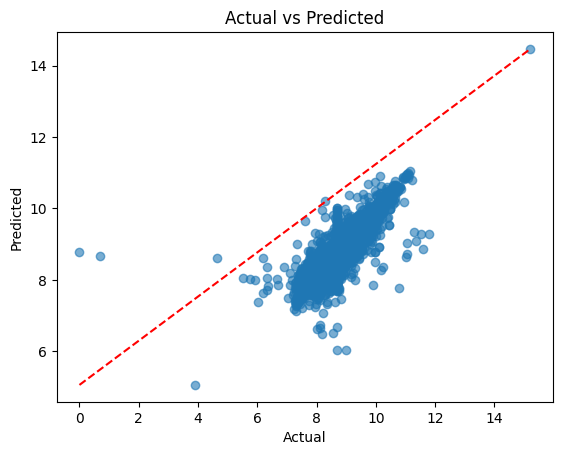

In [196]:
y_pred = rf.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_pred.min(), y_pred.max()],
         'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()